In [1]:
# We first import numpy
import numpy as np

Let's remember the frontal slices of the example tensor $\tilde X$ from the slides:

$$
   X_1 = 
   \left[
   \begin{matrix}
   0  & 2  & 4  & 6\\
   8  & 10 & 12 & 14\\
   16 & 18 & 20 & 22
   \end{matrix}
   \right]
$$

and 

$$
   X_2 =
   \left[
   \begin{matrix}
   1  & 3  & 5  & 7\\
   9  & 11 & 13 & 15\\
   17 & 19 & 21 & 23
   \end{matrix}
   \right]
$$

![tensor_illustration](images/example_tensor.png)


In NumPy, tensors are represented as nested lists: 

In [2]:
# First frontal slice
T1 = np.array([[  0.,   2.,   4.,   6.],
               [  8.,  10.,  12.,  14.],
               [ 16.,  18.,  20.,  22.]])

# Second frontal slice
T2 = np.array([[  1.,   3.,   5.,   7.],
               [  9.,  11.,  13.,  15.],
               [ 17.,  19.,  21.,  23.]])

To create a tensor from the frontal slides, we concatenate them along a new, third dimension.

In [3]:
def tensor_from_frontal_slices(*matrices):
    """Creates a tensor from its frontal slices
    
    Parameters
    ----------
    matrices : 2D-Numpy arrays
    
    Returns
    -------
    tensor : 3D-NumPy arrays
        its frontal slices are the matrices passed as input
    """
    return np.concatenate([matrix[:, :, np.newaxis]\
                          for matrix in matrices], axis=-1)

In [4]:
T = tensor_from_frontal_slices(T1, T2)

Indexing is quite natural: here we are examining the frontal slices by fixing only the third index:

In [5]:
T[:, :, 0]

array([[  0.,   2.,   4.,   6.],
       [  8.,  10.,  12.,  14.],
       [ 16.,  18.,  20.,  22.]])

In [6]:
T[:, :, 1]

array([[  1.,   3.,   5.,   7.],
       [  9.,  11.,  13.,  15.],
       [ 17.,  19.,  21.,  23.]])

Similarly, we can inspect the fibers by fixing all indices but one:

In [7]:
# First column (mode-1 fiber)
T[:, 0, 0]

array([  0.,   8.,  16.])

In [8]:
# First row (mode-2 fiber)
T[0, :, 0]

array([ 0.,  2.,  4.,  6.])

In [9]:
# First tube (mode-3 fiber)
T[0, 0, :]

array([ 0.,  1.])

Because of the definition of the unfolding we chose, unfolding (and folding back) is quite easy: we but the desired dimension first and reshape!

In [10]:
def unfold(tensor, mode):
    """Returns unfolding of a tensor --modes starting at 0.
    
    Parameters
    ----------
    tensor : ndarray
    mode : int (default is 0), mode along which to unfold
           indexing starts at 0
    
    Returns
    -------
    ndarray
        unfolded_tensor of shape
    """
    return np.reshape(np.moveaxis(tensor, mode, 0),
                      (tensor.shape[mode], -1))


def fold(unfolded_tensor, mode, shape):
    """Refolds the unfolding into a full tensor 
    
        In other words, refolds the n-mode unfolded tensor
        into the original tensor of the specified shape.
    
    Parameters
    ----------
    unfolded_tensor : ndarray
        unfolded tensor of shape ``(shape[mode], -1)``
    mode : int
        the mode of the unfolding
    shape : tuple
        shape of the original tensor before unfolding
    
    Returns
    -------
    ndarray
        folded_tensor of shape `shape`
    """
    full_shape = list(shape)
    mode_dim = full_shape.pop(mode)
    full_shape.insert(0, mode_dim)
    return np.moveaxis(np.reshape(
          unfolded_tensor, full_shape), 0, mode)

Next, let's define the khatri-rao product:

In [11]:
def khatri_rao(matrix1, matrix2):
    """Returns the khatri-rao product of m1 and m2
    """
    n_columns = matrix1.shape[1]
    result = np.einsum('ik,jk->ijk', matrix1, matrix2)
    return result.reshape((-1, n_columns))

The next function converst a tensor in the Kruskal form (e.g. a tensor decomposed with CP), back to a whole tensor:

In [12]:
def kruskal_to_tensor(A, B, C):
    """Converts the kruskal form into a tensor
    """
    full_shape = (A.shape[0], B.shape[0], C.shape[0])
    unfolded_tensor = A.dot(khatri_rao(B, C).T)
    return fold(unfolded_tensor, 0, full_shape)

This is quite explicit:

In [13]:
def l2_norm(tensor):
    """Norm 2 of the tensor
    """
    return np.sqrt(np.sum(tensor**2))

Now we are ready to implement the CP decomposition as explained in the slides!

In [14]:
def parafac(tensor, rank, n_iter_max=200, tol=10e-10):
    """CANDECOMP/PARAFAC decomposition via ALS

    Parameters
    ----------
    tensor : ndarray
    rank  : int
            number of components
    n_iter_max : int
                 maximum number of iterations
    tol : float, optional
          tolerance: the algorithm stops when the variation in
          the reconstruction error is less than the tolerance
    verbose : int, optional
        level of verbosity
        
    Returns
    -------
    A, B, C :  factors of the CP decomposition
    """
    A = np.random.random_sample((tensor.shape[0], rank))
    B = np.random.random_sample((tensor.shape[1], rank))
    C = np.random.random_sample((tensor.shape[2], rank))

    # Norm of the input tensor
    norm_tensor = l2_norm(tensor)
    error = None

    for iteration in range(n_iter_max):
        # Update A
        prod = B.T.dot(B)*C.T.dot(C) # TODO
        factor = unfold(tensor, 0).dot(khatri_rao(B, C))
        A = np.linalg.solve(prod.T, factor.T).T

        # Update B
        prod = A.T.dot(A)*C.T.dot(C)
        factor = unfold(tensor, 1).dot(khatri_rao(A, C))
        B = np.linalg.solve(prod.T, factor.T).T
        
        # Update C
        prod = A.T.dot(A)*B.T.dot(B)
        factor = unfold(tensor, 2).dot(khatri_rao(A, B))
        C = np.linalg.solve(prod.T, factor.T).T
        
        # Compute the reconstruction error
        prev_error = error
        rec = kruskal_to_tensor(A, B, C)
        error = l2_norm(tensor - rec) / norm_tensor # TODO l2_norm

        if iteration > 1:
            if tol and abs(prev_error - error) < tol:
                print('converged in {} iterations.'.format(
                      iteration))
                break

    return A, B, C

In [15]:
T.shape

(3, 4, 2)

In [16]:
# decomposed T into factors 
A, B, C = parafac(T, 3)

# reconstruct the full tensor from these
rec = kruskal_to_tensor(A, B, C)

# verify that the reconstruction is correct
np.testing.assert_array_equal(np.round(rec), T)

converged in 6 iterations.


In [17]:
from scipy.misc import face

# Load the face
image = face()

# Convert it to a tensor of floats
image = np.array(image, dtype=np.float64)


def to_image(tensor):
    """convert a tensor of float values into an image
    """
    tensor -= tensor.min()
    tensor /= tensor.max()
    tensor *= 255
    return tensor.astype(np.uint8)

In [18]:
# Apply CP decomposition
A, B, C = factors = parafac(image, rank=50, tol=10e-6)

# Reconstruct the full image
rec = kruskal_to_tensor(A, B, C)

# convert it back to uint8...
rec_image = to_image(rec) # to_numpy -> to_image TODO

converged in 85 iterations.


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


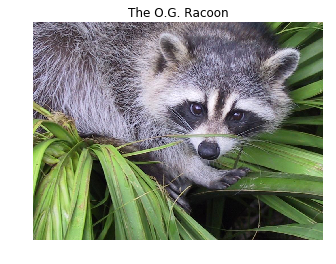

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face())
ax.set_axis_off()
plt.title('The O.G. Racoon')
fig.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


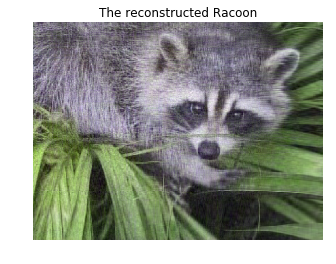

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(rec_image)
ax.set_axis_off()
plt.title('The reconstructed Racoon')
fig.show()

Note that these are simplistic implementations. In practice, we want our algorithms to work for tensors of any order, handle edge cases, etc. For this, we will use TensorLy. See how easy it is to do all the above:

In [22]:
import tensorly as tl
import numpy as np

# Create a random tensor:
T = tl.tensor(np.random.random((10, 10, 10)))

# unfold the tensor:
tl.unfold(T, mode=0)

# Tensor decomposition
from tensorly.decomposition import parafac, tucker

# CP decomposition
factors = parafac(T, rank=3)

# Tucker decomposition
core, factors = tucker(T, ranks=[3, 2, 4])

Using numpy backend.
